In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import pp2
import numpy as np
from matplotlib import style
style.use('ggplot')

In [21]:
# Load QCd Avital mouse data
adata = sc.read_csv("GSE102160_exp_full_time_course_qc_mouse.csv").transpose()  
## all cells as rows and genes as columns
## transpose() swap the rows and column

In [18]:
# Annotate cells and genes
pp2.annotate_cells(adata.obs)  ## rows = obs
pp2.annotate_genes(adata.var)  ## columns = var
adata.var = pp2.join_gene_info(adata.var)  ## add row containing gene info, for each gene in column

FileNotFoundError: [Errno 2] File mouse_genes_RefSeq.csv does not exist: 'mouse_genes_RefSeq.csv'

In [19]:
# Add cluster IDs (calculated in DataPreparation_Mouse) to the annotation
adata.obs = adata.obs.join(pd.read_csv("GSE102160_exp_full_time_course_qc_mouse_cluster_labels.csv", index_col=0))

In [14]:
adata.obs

,time,time_name,exposed,cluster_id
cell,,,,
T0_TC_sample_0002,0,T0,False,0
T0_TC_sample_0003,0,T0,False,0
T0_TC_sample_0005,0,T0,False,0
T0_TC_sample_0006,0,T0,False,0
T0_TC_sample_0007,0,T0,False,0
...,...,...,...,...
T8_TC_sample_0377,8,T8,True,3
T8_TC_sample_0378,8,T8,True,3
T8_TC_sample_0379,8,T8,True,3


In [6]:
# Define a label for which differential expression will be tested
adata.obs["de_target"] = adata.obs.exposed.map(lambda x: "In" if x else "Out")  ## add column, for each cell in row, label all exposed cells as In

In [7]:
# Store UMI values for later use
adata.var["umi_mean"] = adata.X.mean(axis=0)  ## add row containing mean of gene expression, for each gene in column
adata.var["umi_var"] = adata.X.var(axis=0)  ## add row containing variance of gene expression, for each gene in column
adata.var["umi_mean_in"] = adata[adata.obs.de_target == "In"].X.mean(axis=0)  ## add row containing mean of gene expression in exposed cells, for each gene
adata.var["umi_mean_out"] = adata[adata.obs.de_target == "Out"].X.mean(axis=0)  ## add row containing mean of gene expression in cells at t0, for each gene
adata.layers["umi_counts"] = adata.X.copy()

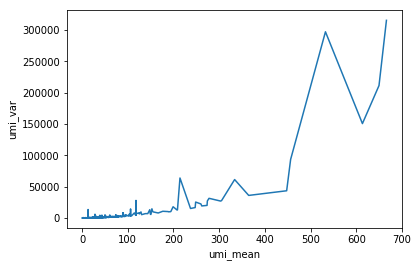

In [8]:
def plot_mean_vs_var(ad, mean_key, var_key):
    #sc.pl.scatter(ad, mean_key, var_key, size=20)
    x, y = zip(*sorted(zip(ad.var[mean_key], ad.var[var_key])))
    plt.plot(x, y)
    plt.xlabel(mean_key)
    plt.ylabel(var_key)
    plt.show()


plot_mean_vs_var(adata, "umi_mean", "umi_var")

In [9]:
# Normalise expression data to counts per 10,000 and take the logarithm
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

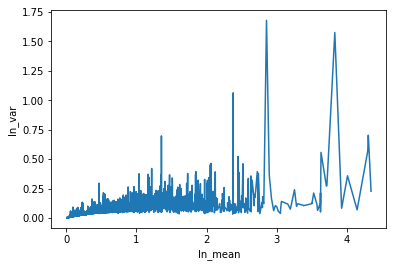

In [10]:
adata.var["ln_mean"] = adata.X.mean(axis=0)  ## add row containing mean of gene expression, for each gene in column
adata.var["ln_var"] = adata.X.var(axis=0)  ## add row containing variance of gene expression, for each gene in column
plot_mean_vs_var(adata, "ln_mean", "ln_var")

In [11]:
# Calculate a t-SNE plot
# Perplexity of 10 taken from Avital et al. (2017)
sc.tl.tsne(adata, use_rep="X", perplexity=10)

... storing 'time_name' as categorical
... storing 'de_target' as categorical
... storing 'organism' as categorical
... storing 'coding' as categorical
... storing 'name' as categorical
... storing 'name_or_id' as categorical


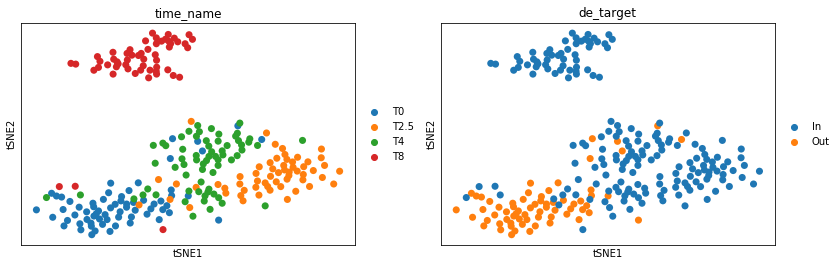

In [12]:
# Display t-SNE plots coloured by time and the DE target groups
tsne_args = dict(size=200)
sc.pl.tsne(adata, color=["time_name", "de_target"], **tsne_args)

In [13]:
adata

AnnData object with n_obs × n_vars = 244 × 17822 
    obs: 'time', 'time_name', 'exposed', 'cluster_id', 'de_target'
    var: 'organism', 'coding', 'name', 'name_or_id', 'umi_mean', 'umi_var', 'umi_mean_in', 'umi_mean_out', 'ln_mean', 'ln_var'
    uns: 'log1p', 'time_name_colors', 'de_target_colors'
    obsm: 'X_tsne'
    layers: 'umi_counts'

In [14]:
# Test for differential expression based on Wilcoxon rank-sum with Benjamini-Hochberg correction
# The Wilcoxon rank-sum test has been shown to perform well for single-cell analysis compared with other methods (Soneson and Robinson, 2018)
sc.tl.rank_genes_groups(adata, groupby="de_target", rankby_abs=True, n_genes=5000,
                        method="wilcoxon", corr_method="benjamini-hochberg")

In [15]:
### visualize data
##sc.pl.rank_genes_groups(adata)

In [16]:
# Extract list of genes with significant (p-value < 0.05) differential expression
de_list = sc.get.rank_genes_groups_df(adata, group="In", pval_cutoff=0.05, gene_symbols="name_or_id")
de_list["umi_mean_all"] = adata.var.loc[de_list.names].umi_mean.values
de_list["umi_mean_out"] = adata.var.loc[de_list.names].umi_mean_out.values
de_list["umi_mean_in"] = adata.var.loc[de_list.names].umi_mean_in.values
print(de_list.shape[0], "differentially expressed genes:")

with pd.option_context("display.max_rows", None):
    display(de_list[:100])

3693 differentially expressed genes:


,scores,names,logfoldchanges,pvals,pvals_adj,name_or_id,umi_mean_all,umi_mean_out,umi_mean_in
0,-10.346096,NR_015491,-1.284624,4.358984e-25,6.202550e-21,A630089N07Rik,152.803284,271.333344,108.853935
1,-10.301175,NM_001101475,-1.345124,6.960554e-25,6.202550e-21,F830016B08Rik,28.446722,51.863636,19.764046
2,-9.954060,NM_001080743,-1.161874,2.421012e-23,1.123876e-19,Grk4,128.930328,217.015152,96.269661
3,-9.949976,NM_175522,-1.185695,2.522446e-23,1.123876e-19,Elfn1,19.282787,33.560608,13.988764
4,-9.882594,NM_001290351,-1.358566,4.953354e-23,1.564052e-19,Zfp37,10.799180,19.954546,7.404494
5,-9.876469,NM_178678,-1.396945,5.265577e-23,1.564052e-19,Lrrtm3,42.729507,77.924240,29.679775
6,9.770292,NM_173033,0.759334,1.510158e-22,3.432741e-19,Tstd2,39.991802,28.060606,44.415730
7,-9.768250,NM_001290512,-1.664612,1.540900e-22,3.432741e-19,Mid1,7.500000,15.212121,4.640450
8,-9.731497,NM_001110253,-1.088759,2.213118e-22,4.105776e-19,Fyco1,114.331970,186.878784,87.432587
9,-9.727413,NM_148925,-1.065968,2.303768e-22,4.105776e-19,Fyco1,114.668030,186.666672,87.971909


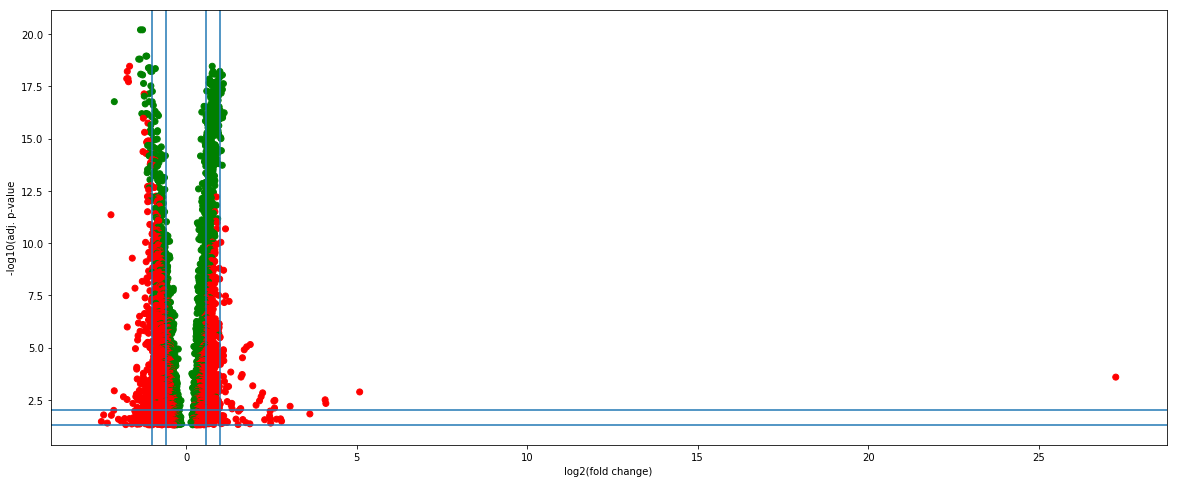

In [17]:
# Show a volcano plot for the DEGs
# Includes cut-off bars for p-values and fold-change

mean_threshold = 10

def p_to_y(pval):
    return -np.log10(pval)

def mean_to_colour(mean):
    return "red" if mean < mean_threshold else "green"

def plot_volcano(df, pvals=[], fcs=[]):
    plt.figure(figsize=(20, 8))
    plt.scatter(x=df.logfoldchanges, y=p_to_y(df.pvals_adj), c=df.umi_mean_all.map(mean_to_colour))
    for pval in pvals:
        plt.axhline(y=p_to_y(pval))
    for fc in fcs:
        fcx = np.log2(fc)
        plt.axvline(x=-fcx)
        plt.axvline(x=fcx)
    plt.xlabel("log2(fold change)")
    plt.ylabel("-log10(adj. p-value")
    plt.show()


plot_volcano(de_list, pvals=[0.01, 0.05], fcs=[1.5, 2])

In [18]:
### new steps 
## Group t8 as an individual group and compare to the T0,T2.5 and T4
adata.obs["t8_target"] = adata.obs.cluster_id.map(lambda x: "In" if x >= 3 else "Out")

In [19]:
# Test for differential expression based on Wilcoxon rank-sum with Benjamini-Hochberg correction
# The Wilcoxon rank-sum test has been shown to perform well for single-cell analysis compared with other methods (Soneson and Robinson, 2018)
sc.tl.rank_genes_groups(adata, groupby="t8_target", rankby_abs=True, n_genes=5000,
                        method="wilcoxon", corr_method="benjamini-hochberg")

... storing 't8_target' as categorical


In [20]:
# Extract list of genes with significant (p-value < 0.05) differential expression
t8_list = sc.get.rank_genes_groups_df(adata, group="In", pval_cutoff=0.05, gene_symbols="name_or_id")
t8_list["umi_mean_all"] = adata.var.loc[t8_list.names].umi_mean.values
t8_list["umi_mean_out"] = adata.var.loc[t8_list.names].umi_mean_out.values
t8_list["umi_mean_in"] = adata.var.loc[t8_list.names].umi_mean_in.values
print(t8_list.shape[0], "differentially expressed genes:")
t8_list.sort_values(by=['logfoldchanges'])
pd.set_option('display.max_rows', 500)

##with pd.option_context("display.max_rows", None):
 ##   display(t8_list[:100])

NameError: name '_list' is not defined

In [ ]:
t8_list = t8_list[t8_list["umi_mean_all"] >20]
t8_list = t8_list[abs(t8_list["logfoldchanges"]) > 1]
print("the size of DEGs list: ", t8_list.shape[0])
t8_list